<a href="https://colab.research.google.com/github/mhdi002/med_Ai/blob/main/ESMFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time

version = "1" # @param ["0", "1"]
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

installing libs...
installing openfold...
installing esmfold...
CPU times: user 956 ms, sys: 165 ms, total: 1.12 s
Wall time: 5min 8s


In [49]:

%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "GPETLCGAELVDALQFVCGDRGFYFNKPTGYGSSSRRAPQTGIVDECCFRSCDLRRLEMYCAPLKPAKSA" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name, weights_only=False)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 70
ptm: 0.600 plddt: 71.949
CPU times: user 1.72 s, sys: 21.1 ms, total: 1.74 s
Wall time: 1.75 s


In [50]:

import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

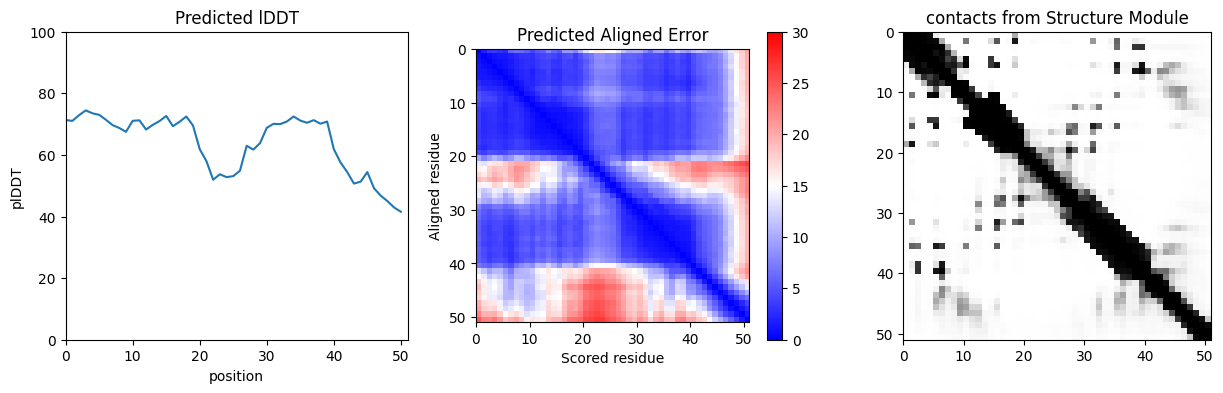

In [45]:


dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [31]:

from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:

from ipywidgets import widgets
from IPython.display import display, clear_output
import py3Dmol
from string import ascii_uppercase, ascii_lowercase
import os

# Create a more persistent 3D viewer that won't disappear
class PersistentViewer:
    def __init__(self):
        self.viewer_output = widgets.Output()
        self.pdb_text = widgets.Textarea(
            placeholder='Paste PDB content here or load from a saved PDB file',
            layout=widgets.Layout(width='100%', height='100px'),
            style={'description_width': 'initial'}
        )

        self.file_selector = widgets.Dropdown(
            options=['No saved PDBs found'],
            description='Load saved PDB:',
            layout=widgets.Layout(width='50%'),
            style={'description_width': 'initial'}
        )

        self.color_selector = widgets.Dropdown(
            options=['pLDDT', 'rainbow', 'chain'],
            value='pLDDT',
            description='Color scheme:',
            style={'description_width': 'initial'}
        )

        self.show_sidechains = widgets.Checkbox(
            value=True,
            description='Show sidechains',
            style={'description_width': 'initial'}
        )

        self.show_mainchains = widgets.Checkbox(
            value=True,
            description='Show mainchains',
            style={'description_width': 'initial'}
        )

        self.display_button = widgets.Button(
            description='Display Structure',
            button_style='success',
            tooltip='Display the 3D structure'
        )

        self.refresh_button = widgets.Button(
            description='Refresh PDB List',
            button_style='info',
            tooltip='Refresh the list of available PDB files'
        )

        # Button handlers
        self.display_button.on_click(self._on_display)
        self.refresh_button.on_click(self._refresh_pdb_list)
        self.file_selector.observe(self._on_file_selected, names='value')

        # Initialize
        self._refresh_pdb_list()

        # Layout
        self.controls = widgets.HBox([
            self.file_selector,
            self.refresh_button
        ])

        self.display_controls = widgets.HBox([
            self.color_selector,
            self.show_sidechains,
            self.show_mainchains,
            self.display_button
        ])

        self.ui = widgets.VBox([
            widgets.HTML("<h3>Persistent 3D Protein Viewer</h3>"),
            self.controls,
            self.pdb_text,
            self.display_controls,
            self.viewer_output
        ])

    def _on_display(self, b):
        """Display the PDB structure"""
        pdb_str = self.pdb_text.value
        if not pdb_str.strip():
            with self.viewer_output:
                clear_output(wait=True)
                print("No PDB data to display.")
            return

        with self.viewer_output:
            clear_output(wait=True)
            print("Rendering 3D structure...")
            view = self._show_pdb(
                pdb_str,
                color=self.color_selector.value,
                show_sidechains=self.show_sidechains.value,
                show_mainchains=self.show_mainchains.value
            )
            view.show()

    def _on_file_selected(self, change):
        """Load selected PDB file content"""
        if change['new'] == 'No saved PDBs found' or not change['new']:
            return

        filename = change['new']
        try:
            with open(filename, 'r') as f:
                self.pdb_text.value = f.read()
            print(f"Loaded {filename}")
        except Exception as e:
            print(f"Error loading file: {str(e)}")

    def _refresh_pdb_list(self, b=None):
        """Refresh the list of available PDB files"""
        pdb_files = []
        # Look in current directory and all subdirectories for PDB files
        for root, dirs, files in os.walk('.'):
            for file in files:
                if file.endswith('.pdb'):
                    pdb_files.append(os.path.join(root, file))

        if pdb_files:
            self.file_selector.options = pdb_files
        else:
            self.file_selector.options = ['No saved PDBs found']

    def _show_pdb(self, pdb_str, show_sidechains=False, show_mainchains=False,
                 color="pLDDT", chains=None, vmin=50, vmax=90,
                 size=(800,480), hbondCutoff=4.0,
                 Ls=None,
                 animate=False):
        """Display a PDB structure"""
        pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                          "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                          "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                          "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                          "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]
        alphabet_list = list(ascii_uppercase+ascii_lowercase)

        if chains is None:
            # Automatically detect number of chains from the PDB
            chain_set = set()
            for line in pdb_str.split('\n'):
                if line.startswith("ATOM  ") or line.startswith("HETATM"):
                    chain_id = line[21]
                    chain_set.add(chain_id)
            chains = len(chain_set)

        view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
        if animate:
            view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
        else:
            view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

        if color == "pLDDT":
            view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
        elif color == "rainbow":
            view.setStyle({'cartoon': {'color':'spectrum'}})
        elif color == "chain":
            for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
               view.setStyle({'chain':chain},{'cartoon': {'color':color}})

        if show_sidechains:
            BB = ['C','O','N']
            view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                          {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
            view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                          {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
            view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                          {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

        if show_mainchains:
            BB = ['C','O','N','CA']
            view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

        view.zoomTo()
        if animate: view.animate()
        return view

    def display(self):
        """Display the widget"""
        display(self.ui)

# Create and display the viewer
viewer = PersistentViewer()
viewer.display()

Loaded ./test_518d3/ptm0.817_r3_default.pdb
